In [1]:
import os
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau


## Import the Stanford Dogs dataset 
We take a subsample of 40 classes out of the actual 120 classes due to computational constraints.

In [2]:
# Extract the data
# import tarfile
  
# # open file
# file = tarfile.open('images.tar')
  
# # extracting file
# file.extractall('StanfordDogs2')
  
# file.close()

In [3]:
#setting the folder names for each dog class to the name of the breed
# import os
# target = []
# DIR = "StanfordDogs2/Images/"
# for name in os.listdir(DIR):    
#     os.rename("StanfordDogs2/Images/"+name,"StanfordDogs2/Images/"+name.split('-',1)[1])

In [4]:
train_data_dir = "StanfordDogs2/Images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [5]:
import os
import numpy as np
from PIL import Image
train_directory = "StanfordDogs2/Images" 
image_list=[]
label_list=[]
for sub_dir in os.listdir(train_directory):
    print("Reading folder {}".format(sub_dir))
    sub_dir_name=os.path.join(train_directory,sub_dir)
    for file in os.listdir(sub_dir_name):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_list.append(np.array(Image.open(os.path.join(sub_dir_name,file))))
            label_list.append(sub_dir)
X=np.array(image_list)
y=np.array(label_list)


Reading folder Norwegian_elkhound
Reading folder Blenheim_spaniel
Reading folder Shih-Tzu
Reading folder Newfoundland
Reading folder Doberman
Reading folder Great_Dane
Reading folder standard_schnauzer
Reading folder groenendael
Reading folder Siberian_husky
Reading folder miniature_schnauzer
Reading folder Labrador_retriever
Reading folder cairn
Reading folder Japanese_spaniel
Reading folder EntleBucher
Reading folder papillon
Reading folder Rottweiler
Reading folder Scottish_deerhound
Reading folder Pembroke
Reading folder cocker_spaniel
Reading folder basset
Reading folder Staffordshire_bullterrier
Reading folder vizsla
Reading folder Leonberg
Reading folder Australian_terrier
Reading folder Chesapeake_Bay_retriever
Reading folder Sealyham_terrier
Reading folder Boston_bull
Reading folder wire-haired_fox_terrier
Reading folder Samoyed
Reading folder Saluki
Reading folder Irish_water_spaniel
Reading folder Walker_hound
Reading folder briard
Reading folder pug
Reading folder basenji
R

/home/ecbm4040/envTF24/lib/python3.6/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


## Data Preprocessing and Augmentation

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 5801 images belonging to 40 classes.
Found 1434 images belonging to 40 classes.


### Train-Test Dataset Preparation

In [8]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes) #one hot encoding of output variables
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)  #one hot encoding of output variables
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

## Transfer Learning with MobileNet for our application

In [9]:
import tensorflow as tf
model = tf.keras.applications.MobileNetV2(input_shape= (img_width, img_height, channels), alpha=0.75,
                                               include_top=False,
                                               weights='imagenet') #keep changing values of alpha and input_shape
model.summary()

Model: "mobilenetv2_0.75_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 24) 96          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 24) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
model.trainable = False

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(40,activation='softmax')


In [12]:
model = tf.keras.Sequential([
  model,
  global_average_layer,
  prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.75_224 (Functi (None, 7, 7, 1280)        1382064   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 40)                51240     
Total params: 1,433,304
Trainable params: 51,240
Non-trainable params: 1,382,064
_________________________________________________________________


In [13]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

/home/ecbm4040/envTF24/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)


reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [earlystop,reduceLR]

In [15]:
history = model.fit(
    train_generator, 
    epochs = 10,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10
90/90 - 166s - loss: 1.7565 - accuracy: 0.5492 - val_loss: 0.8547 - val_accuracy: 0.7621
Epoch 2/10
90/90 - 159s - loss: 0.7890 - accuracy: 0.7750 - val_loss: 0.6713 - val_accuracy: 0.7947
Epoch 3/10
90/90 - 164s - loss: 0.6506 - accuracy: 0.8056 - val_loss: 0.6140 - val_accuracy: 0.8111
Epoch 4/10
90/90 - 160s - loss: 0.5793 - accuracy: 0.8257 - val_loss: 0.5644 - val_accuracy: 0.8189
Epoch 5/10
90/90 - 157s - loss: 0.5259 - accuracy: 0.8386 - val_loss: 0.5478 - val_accuracy: 0.8310
Epoch 6/10
90/90 - 158s - loss: 0.4776 - accuracy: 0.8536 - val_loss: 0.5530 - val_accuracy: 0.8253
Epoch 7/10
90/90 - 165s - loss: 0.4458 - accuracy: 0.8630 - val_loss: 0.5323 - val_accuracy: 0.8260
Epoch 8/10
90/90 - 176s - loss: 0.4310 - accuracy: 0.8674 - val_loss: 0.5400 - val_accuracy: 0.8232
Epoch 9/10
90/90 - 170s - loss: 0.3978 - accuracy: 0.8782 - val_loss: 0.5476 - val_accuracy: 0.8203
Epoch 10/10
90/90 - 157s - loss: 0.3809 - accuracy: 0.8857 - val_loss: 0.5528 - val_accuracy: 0.8232

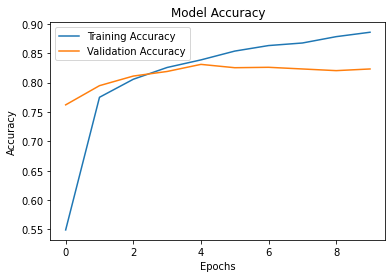

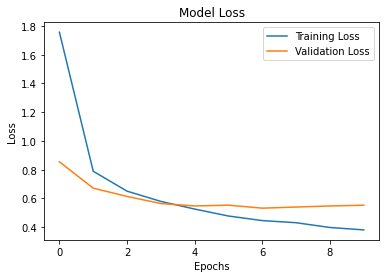

In [16]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()